In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# __file__ = '/content/drive/MyDrive/aiffelthon/data'
 __file__ = '/content/drive/MyDrive/git_path_finding/path-finding-rl/data'

Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Environment

In [76]:
from string import ascii_uppercase
#from draw_utils import *
#from pyglet.gl import *
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

#__file__ = '/home/ogangza/heung_path_finding/path-finding-rl/data' ## GCP용
local_path = os.path.abspath(os.path.join(os.path.dirname(__file__)))

class Simulator:
    def __init__(self):
        # 데이터 로드, 그리드월드 크기 지정
        self.files = pd.read_csv(os.path.join(local_path, "data/factory_order_train.csv"))
        self.height = 10 # 그리드 높이
        self.width = 9 # 그리드 너비
        self.inds = list(ascii_uppercase)[:17] #inds : A ~ Q alphabet list
        self.x = None
        self.y = None

    def set_box(self): # env.target에 이번에 방문해야 할 좌표 저장
        box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))
        order_item = list(set(self.inds) & set(self.items))  # 에피소드에 해당하는 items는 reset 메서드에서 결정
        order_csv = box_data[box_data['item'].isin(order_item)]
        for order_box in order_csv.itertuples(index = True, name ='Pandas'):
            self.target.append([getattr(order_box, "row"), getattr(order_box, "col")] )
        ###############################################################
        self.target.append([9,4]) # 최종 목적지 (출발점) 추가
        ###############################################################
        
    def reset(self, epi): #  첫 스텝에서 사용. start point에 있게 한다.
        # initial episode parameter setting
        self.epi = epi
        self.target = []
        self.items = list(self.files.iloc[self.epi])[0]  # 해당 에피소드의 items를 가져 옴. 예, [ 'H', 'L', 'M']
        self.set_box()  # 에이전트가 이번에 방문해야 할 좌표들 저장. 예, [ [0,3], [0,7], [0,8], [9,4] ]
        # → 결과 self.target에 들어 옴
        (self.end_x, self.end_y) = self.target[0] # 에피소드의 출발점 <- 이 아니라서 수렴이 안된 것입니다
        (self.x, self.y) = (9, 4)
        return (self.x, self.y), (self.end_x, self.end_y) 

    def step(self, action):
        cur_x, cur_y = self.x, self.y
        if action == 0:     # up
            self.move_up()
        elif action == 1:   # down
            self.move_down()
        elif action == 2:   # left
            self.move_left()
        elif action == 3:   # right
            self.move_right()
        new_x, new_y = self.x, self.y

        if (cur_x, cur_y) == (new_x, new_y):
            reward = -10
        else:
            reward = -1
        done = self.is_done()
        if done:
            reward = 1000
        return (self.x, self.y), reward, done

    def move_up(self):  # action == 0:
        if self.x == 0:
            pass
        elif self.x == 6 and self.y in [0,8]:
            pass
        elif self.x == 7 and self.y in [2,4,6]:
            pass
        else:
            self.x -= 1

    def move_down(self): # action == 1:
        if self.x == 9:
            pass
        elif self.x == 8 and self.y in [0,1,2,3,5,6,7,8]:
            pass
        elif self.x == 2 and self.y in [2,4,6]:
            pass
        elif self.x in [1,2,3,4,5] and self.y in [0,8]:
            pass
        else:
            self.x += 1
        
    def move_left(self): # left elif action == 2:
        if self.y == 0:
            pass
        elif self.y == 1 and self.x in [2,3,4,5]:
            pass
        elif self.y in [3,5,7] and self.x in [3,4,5,6]:
            pass
        elif self.y in [1,2,3,4,5,6,7,8] and self.x == 9:
            pass
        else:
            self.y -= 1

    def move_right(self): # right else: action == 3:
        if self.y == 8:
            pass
        elif self.y == 7 and self.x in [2,3,4,5]:
            pass
        elif self.y in [1,3,5] and self.x in [3,4,5,6]:
            pass
        elif self.y in [0,1,2,3,4,5,6,7] and self.x == 9:
            pass
        else:
            self.y += 1

    def is_done(self):
        if self.x == self.end_x and self.y == self.end_y:
            return True
        else:
            return False

## Agent

In [82]:
class QAgent():
    def __init__(self):
        self.height = env.height # 그리드 높이
        self.width = env.width # 그리드 너비
        self.q_table = np.zeros((self.height, self.width, 4)) # 마찬가지로 Q 테이블을 0으로 초기화
        self.eps = 0.5
        self.alpha = 1

    def select_action(self, s):  # eps-greedy로 액션을 선택해준다
        x, y = s
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = self.q_table[x,y,:]
            action = np.argmax(action_val)
        return action

    def update_table(self, transition):
        s, a, r, s_prime = transition
        x,y = s
        next_x, next_y = s_prime
        # Q러닝 업데이트 식을 이용 
        self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha * (r + np.amax(self.q_table[next_x,next_y,:]) - self.q_table[x,y,a])

    def anneal_eps(self):
        self.eps -= 0.01  # Q러닝에선 epsilon 이 좀더 천천히 줄어 들도록 함.
        self.eps = max(self.eps, 0.2) 

    def show_table(self):
        q_lst = self.q_table.tolist()
        data = np.zeros((self.height, self.width))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx, col_idx] = action
        print(data)
        #상, 하, 좌, 우 = 0, 1, 2, 3
        data_direction = np.where(data == 2., '←', data)
        data_direction = np.where(data == 0., '↑', data_direction)
        data_direction = np.where(data == 3., '→', data_direction)
        data_direction = np.where(data == 1., '↓', data_direction)
        data_direction[9,4] = 'S'
        data_direction[9,4] = 'G'
        # 맨 아래 줄
        for i in range(4):
            data_direction[9,i] = '■'
        for i in range(5,9):
            data_direction[9,i] = '■'
        # 맨 윗 줄
        upper_line = 'ⓔⓕⓖⓗⓘⓙⓚⓛⓜ'
        for i in range(9):
            data_direction[0,i] = upper_line[i]
        # 왼쪽, 오른쪽 줄
        left_line = 'ⓓⓒⓑⓐ'
        right_line = 'ⓝⓞⓟⓠ'
        for i in range(2,6):
            data_direction[i,0] = left_line[i-2]
            data_direction[i,8] = right_line[i-2]
        # 중간 장애물
        for i in range(3,7):
            data_direction[i,2] = '■'
            data_direction[i,4] = '■'
            data_direction[i,6] = '■'
        print(data_direction)

In [16]:
# 최적 경로 받는 함수
def optimal_path(start, end):
    x, y = start
    end_x, end_y = end
    local_optimal_path = [[x,y]]  # 최적 경로 시작점 지정
    print('start:', start, end=" ")
    while [x, y] != [end_x, end_y]:
        # select action
        action_val = agent.q_table[x,y,:]
        action = np.argmax(action_val)
        # step action
        if action == 0:
            x -= 1
        elif action == 1:
            x += 1
        elif action == 2:
            y -= 1
        elif action == 3:
            y =+ 1
        local_optimal_path.append([x,y])
        print('→', x,y, end=' ')
    return local_optimal_path

### Qlearning Main

In [90]:
tz = pytz.timezone('Asia/Seoul')
env = Simulator()
agent = QAgent()

# 최초의 start, end point 결정은 env.reset(epi)
epi = 0
start, end = env.reset(epi)
print('list(env.files.iloc[0])[0]:', list(env.files.iloc[0])[0])
print(env.target)
print(start, end)
agent.q_table = np.zeros((env.height, env.width, 4))

cum_reward = 0
optimal_paths = []
for idx, tg in enumerate(env.target):
    cum_reward = 0
    for iter in range(5000): 
        env.x, env.y = start
        env.end_x, env.end_y = end
        done = False
        while not done:  
            a = agent.select_action(s) # e-greedy로 액션 선택
            s_prime, r, done = env.step(a)  
            # print(s,r)
            agent.update_table((s, a, r, s_prime))
            s = s_prime
            cum_reward += r
        agent.anneal_eps()  # epsilon 조정 후 최적해 찾기 반복
        # print(cum_reward)
        cum_reward = 0

    agent.show_table()
    agent.q_table = np.zeros((env.height, env.width, 4))
    print(start,end)
    # optimal_paths += optimal_path(start, end) <- optimal_path가 잘 작동하지 않습니다.
    start = end
    try:
        end = env.target[idx+1]
        print(start, end)
        env.x, env.y = start
        env.end_x, env.end_y = end
    except:
        pass

list(env.files.iloc[0])[0]: ['H', 'L', 'M']
[[0, 3], [0, 7], [0, 8], [9, 4]]
(9, 4) (0, 3)
[[3. 3. 3. 0. 2. 2. 2. 2. 2.]
 [0. 3. 0. 0. 0. 0. 1. 2. 0.]
 [0. 0. 2. 3. 0. 0. 2. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 2. 3. 3. 0. 2. 2. 2.]
 [0. 3. 0. 3. 0. 2. 2. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[['ⓔ' 'ⓕ' 'ⓖ' 'ⓗ' 'ⓘ' 'ⓙ' 'ⓚ' 'ⓛ' 'ⓜ']
 ['↑' '→' '↑' '↑' '↑' '↑' '↓' '←' '↑']
 ['ⓓ' '↑' '←' '→' '↑' '↑' '←' '←' 'ⓝ']
 ['ⓒ' '↑' '■' '↑' '■' '↑' '■' '↑' 'ⓞ']
 ['ⓑ' '↑' '■' '↑' '■' '↑' '■' '↑' 'ⓟ']
 ['ⓐ' '↑' '■' '↑' '■' '↑' '■' '↑' 'ⓠ']
 ['→' '↑' '■' '↓' '■' '↑' '■' '↑' '↓']
 ['↑' '↑' '←' '→' '→' '↑' '←' '←' '←']
 ['↑' '→' '↑' '→' '↑' '←' '←' '↑' '←']
 ['■' '■' '■' '■' 'G' '■' '■' '■' '■']]
(9, 4) (0, 3)
(0, 3) [0, 7]
[[3. 3. 1. 3. 3. 3. 3. 3. 2.]
 [3. 3. 3. 0. 0. 0. 3. 0. 2.]
 [0. 0. 0. 0. 0. 2. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [3. 1. 0

탐색이 부족해 완벽하진 않지만, 얼추 수렴하는 것 확인했어요

코드가 이쁘게 짜여있지않은데, 좀 손봐서 시작위치, 끝위치 잘 나오게 하시면 될꺼같습니다.

이상하게 optimal_path가 위에 정책따라서 움직이지않고 이상하게 움직입니다. 

저기 손 본 다음에 리스트에 더해주는 방식으로 최적루트 리스트를 얻을 수 있을 것 같습니다. (주석처리해놓음)

In [91]:
optimal_path(start, end)

start: [9, 4] 

[[9, 4]]

### Grid World

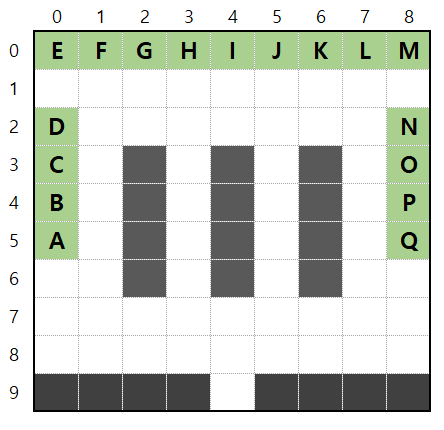